In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import datetime
import math
import numpy as np
import torch
import gpytorch
import imp
import matplotlib.pyplot as plt
%matplotlib inline

import excursion
import excursion.utils as utils
#import excursion.testcases.fast as scandetails
import excursion.testcases.fast_2D as testcase_details

import excursion.active_learning as active_learning
import excursion.plotting.twodim as plots


from excursion.utils import get_first_max_index,point_entropy, mesh2points, points2mesh, values2mesh
np.warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/numpy/lib/index_tricks.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  nn[k] = (nn[k]*step+start)


## 0) Init

True frunctions, thresholds, grid, training data

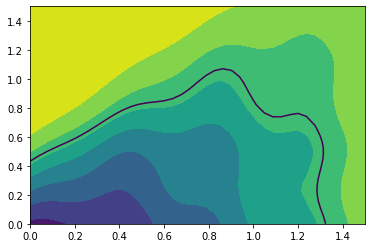

In [3]:
for func in testcase_details.true_functions:
    grid = ix,iy = testcase_details.plot_meshgrid
    X = excursion.utils.mesh2points(grid,testcase_details.rangedef[:,2])
    cont = excursion.utils.values2mesh(func(X), testcase_details.rangedef, testcase_details.invalid_region)
    plt.contourf(ix,iy,cont)
    plt.contour(ix,iy,cont, levels = [1], color='white')
    #plt.contour(ix,iy,cont, levels = [0], color='black')

In [4]:
#training data
#initialize it...
N_INIT  = 5

np.random.seed(2)
indexs = np.random.choice(range(len(X)), replace=False, size=N_INIT)

X_train = [X[i] for i in indexs]
y_train = [func(x.reshape(1,-1)) for x in X_train]
X_train = np.vstack(X_train)
y_train = np.vstack(y_train)

print('X_train = ', X_train, '\n')
print('y_train = ', y_train)

X_train =  [[1.3125 0.675 ]
 [0.1125 0.75  ]
 [0.8625 0.3375]
 [1.0125 0.2625]
 [0.7125 0.6   ]] 

y_train =  [[ 1.7775924 ]
 [ 8.39154939]
 [-6.11150785]
 [-1.57493639]
 [-4.90147145]]


## 1) GP Model Selection


In [5]:
grid_bounds = [(0, 1), (0, 1)]
grid_size = 101
grid = torch.zeros(grid_size, len(grid_bounds), dtype=torch.double)
for i in range(len(grid_bounds)):
    grid[:, i] = torch.linspace(grid_bounds[i][0] , grid_bounds[i][1], grid_size, dtype=torch.double)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).view(-1,)

In [6]:
class GridGPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, grid, train_x, train_y, likelihood):
        super(GridGPRegressionModel, self).__init__(train_x, train_y, likelihood)
        num_dims = train_x.size(-1)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridKernel(gpytorch.kernels.RBFKernel(), grid=grid)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## 2) Likelihood

In [7]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.tensor([0.], dtype=torch.double)) 

## 3) Fit model with training data

In [8]:
model = GridGPRegressionModel(grid, X_train, y_train, likelihood)

In [9]:
model.train()
likelihood.train()
excursion.fit_hyperparams(model,likelihood)

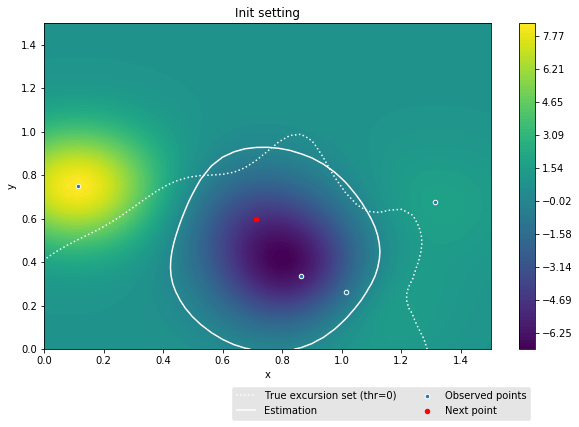

In [10]:
fig = plt.figure(figsize=(10, 6))
plt.title('Init setting')
obj = plots.plot_GP(plt, model, testcase_details)

## 4) Active learning

In [11]:
acq_type = 'MES' #predictive entropy search

In [12]:
################# make eval for all at the same timeeeeee
######NEXT AFTERNOON

TIME TAKEN** 6.282431494000001
Iteration 1, x_new tensor([[0.5625, 0.0750]], dtype=torch.float64) 

TIME TAKEN** 6.2211098379999985
Iteration 2, x_new tensor([[1.4625, 1.0125]], dtype=torch.float64) 

TIME TAKEN** 5.752041651999999
Iteration 3, x_new tensor([[1.0875, 0.7500]], dtype=torch.float64) 

TIME TAKEN** 5.662517683999997
Iteration 4, x_new tensor([[0.0000, 0.1500]], dtype=torch.float64) 

TIME TAKEN** 5.690982214999998
Iteration 5, x_new tensor([[1.4250, 0.5250]], dtype=torch.float64) 

TIME TAKEN** 5.700156215
Iteration 6, x_new tensor([[1.0500, 1.1250]], dtype=torch.float64) 

TIME TAKEN** 5.7506223449999965
Iteration 7, x_new tensor([[0.5250, 0.9750]], dtype=torch.float64) 

TIME TAKEN** 5.620687685
Iteration 8, x_new tensor([[0.2625, 1.5000]], dtype=torch.float64) 

TIME TAKEN** 5.668129925999999
Iteration 9, x_new tensor([[0.2250, 0.4875]], dtype=torch.float64) 

TIME TAKEN** 5.801541251999993
Iteration 10, x_new tensor([[0.9000, 0.7500]], dtype=torch.float64) 

TIME TAKE

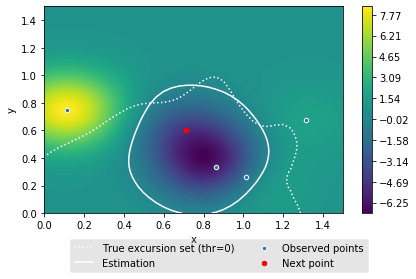

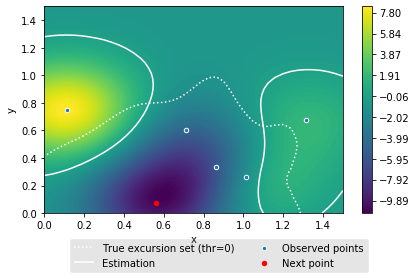

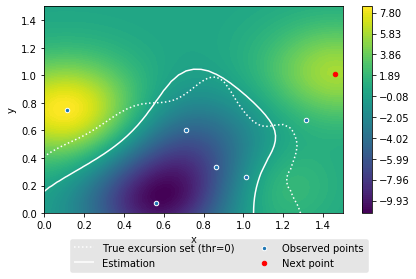

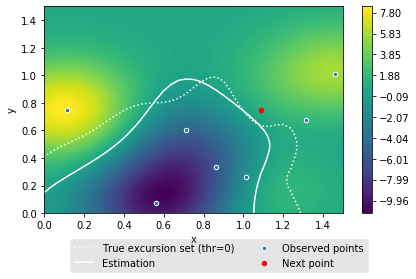

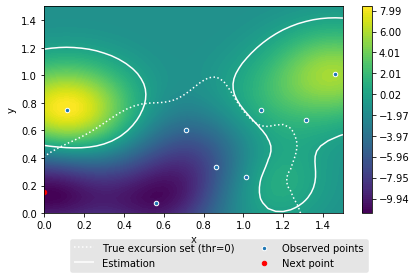

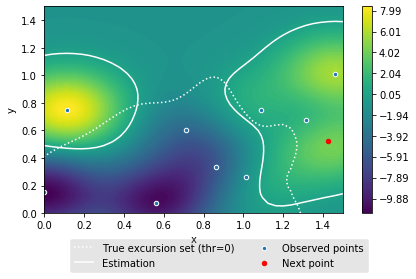

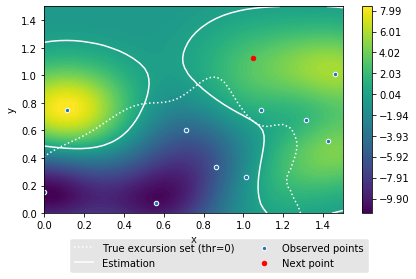

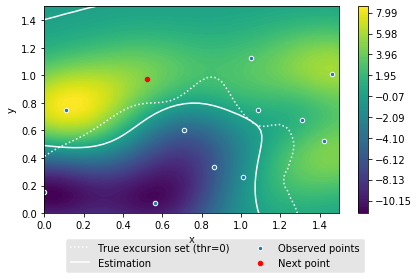

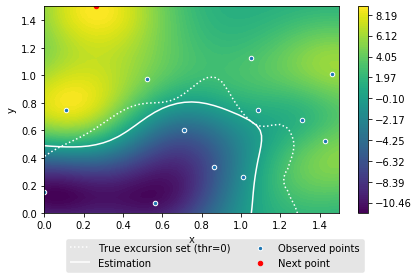

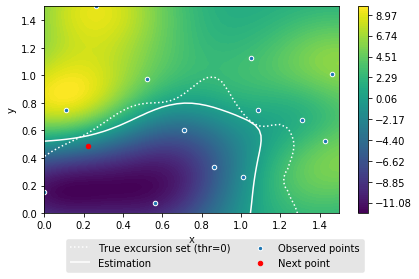

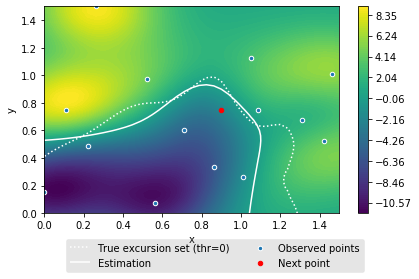

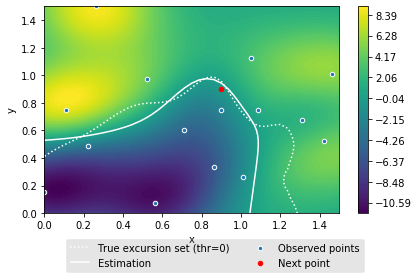

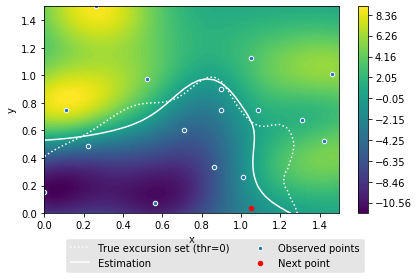

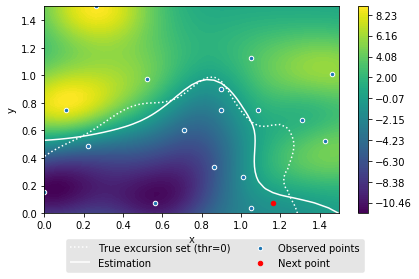

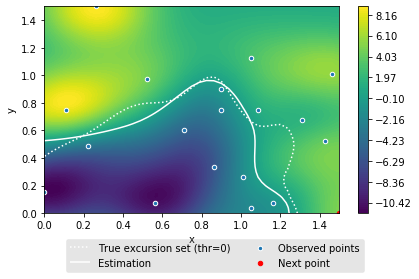

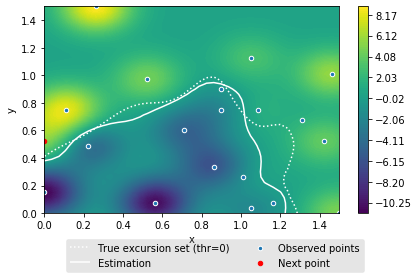

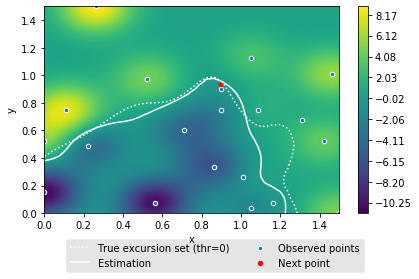

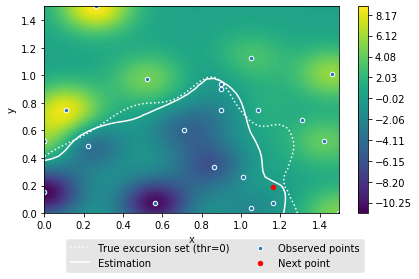

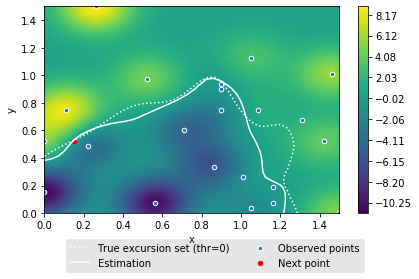

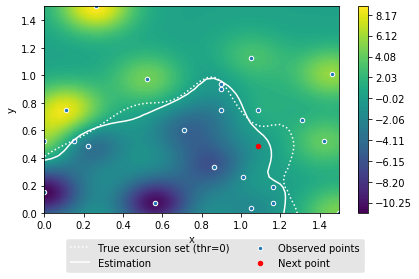

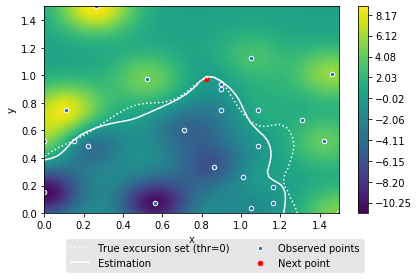

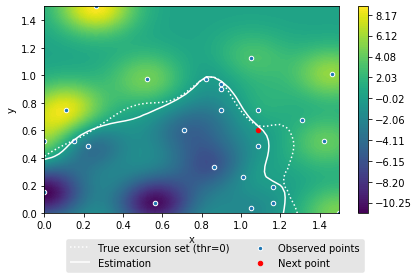

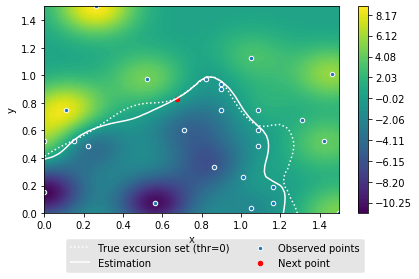

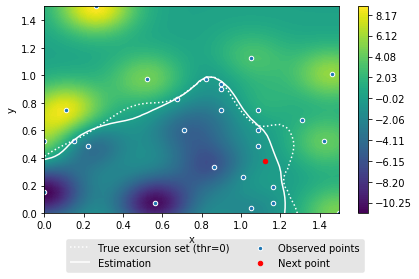

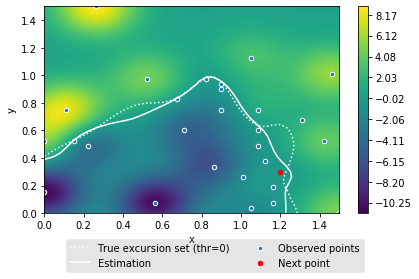

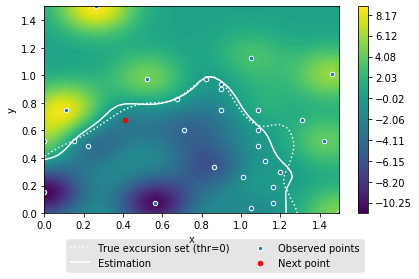

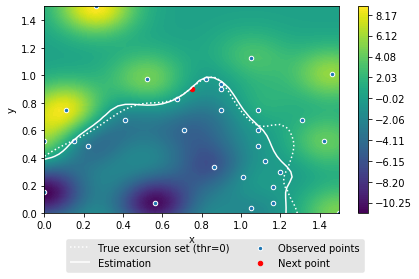

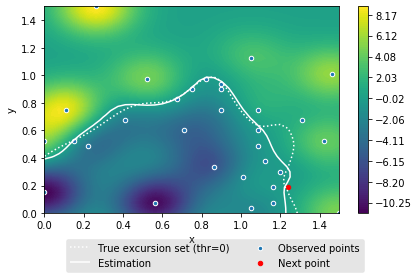

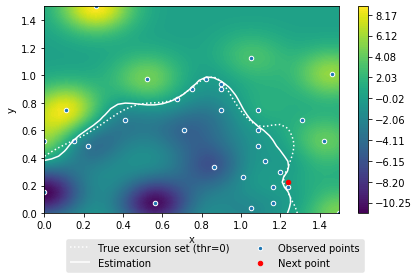

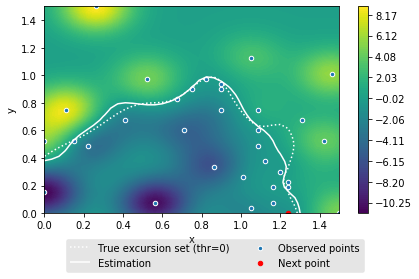

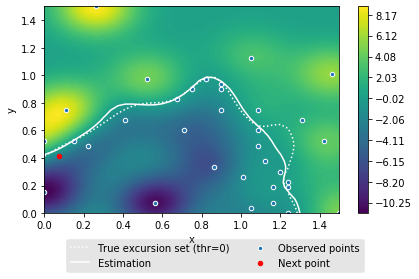

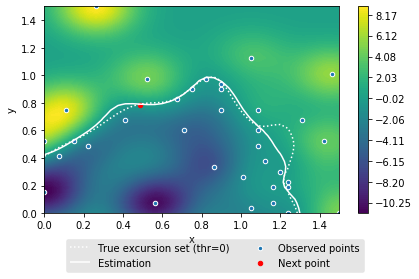

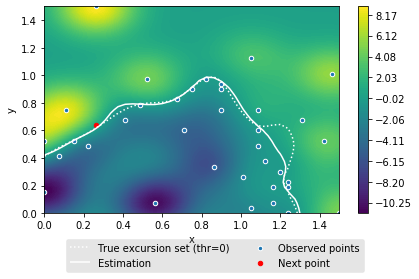

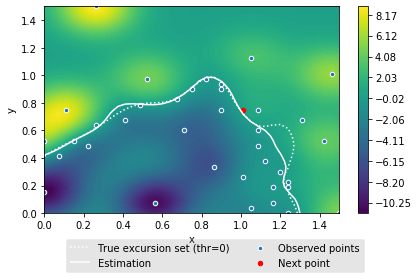

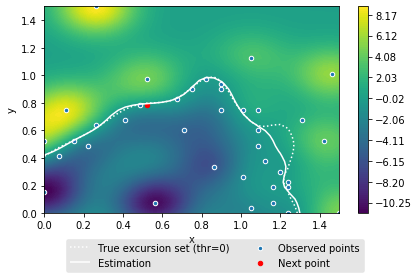

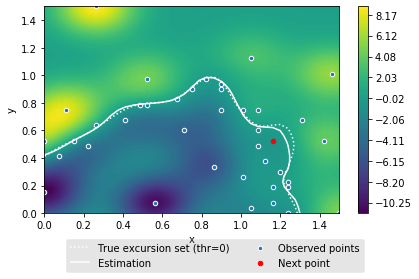

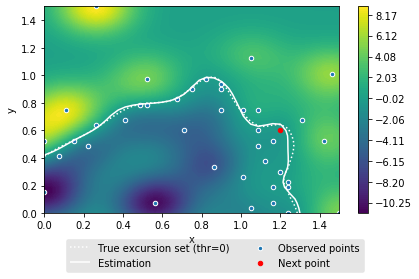

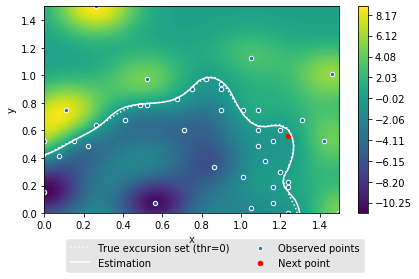

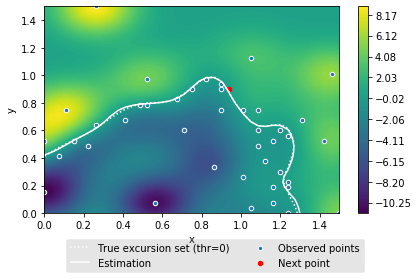

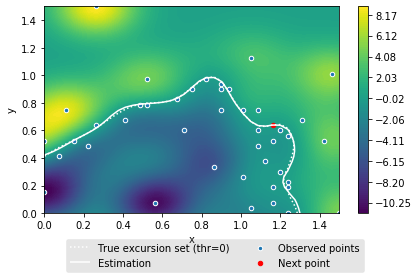

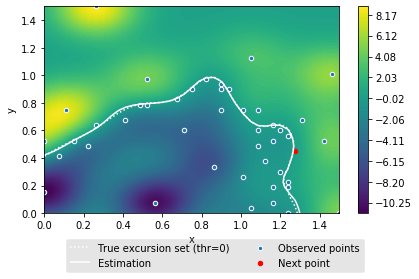

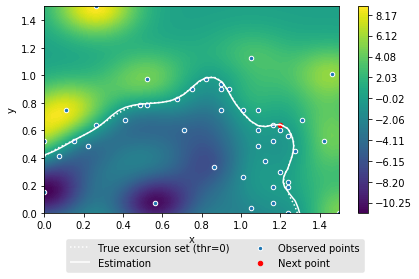

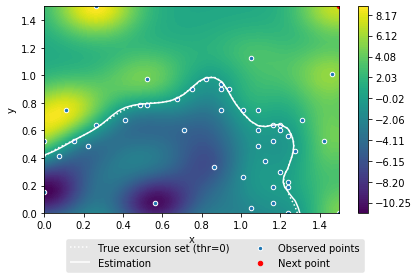

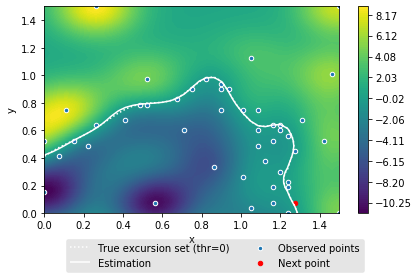

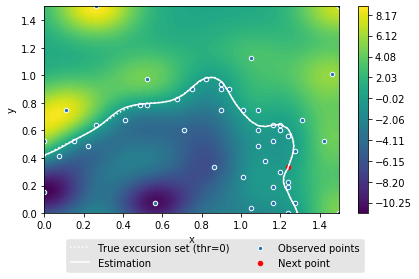

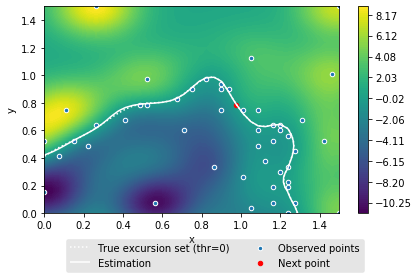

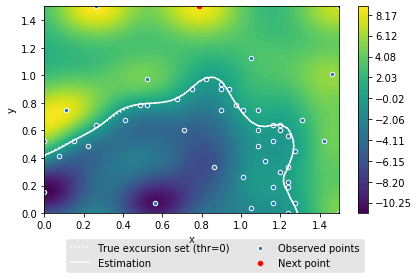

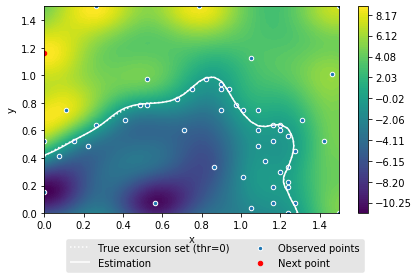

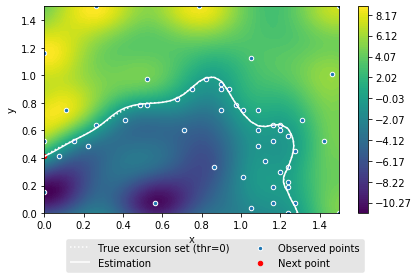

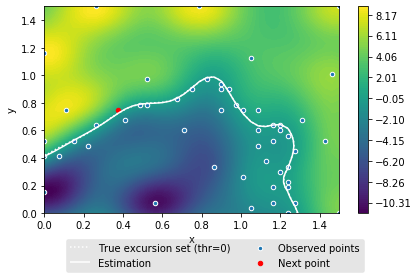

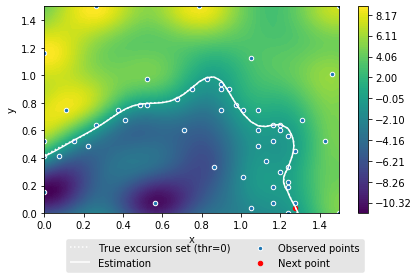

In [13]:
import time

n_iter = 50
plt.figure()
plot = plots.plot_GP(plt,model, testcase_details) 
plt.tight_layout()
plt.savefig('2D_'+str(0)+'.png')

for i in range(1,n_iter+1):
    fig = plt.figure()
    start = time.process_time()

    #find x_new by maximizing acq)(x)
    acquisition_values_grid = []
    for x in testcase_details.X:
        value = active_learning.acq(model,testcase_details, x.view(-1,2), acq_type)
        acquisition_values_grid.append(value)
        
    print('TIME TAKEN**', time.process_time() - start)    
    new_indexs = np.argsort(acquisition_values_grid)[::-1] #descending order
        
    ##discard those points already in dataset
    new_index = get_first_max_index(model, new_indexs, testcase_details)
    
    ##get x, y
    x_new = testcase_details.X[new_index].reshape(1,-1)
    y_new = testcase_details.true_functions[0](x_new)
    
    #update dataset
    inputs_i = torch.cat((model.train_inputs[0], x_new),0)
    targets_i = torch.cat((model.train_targets.view(-1,), y_new),0).flatten()
    model.set_train_data(inputs=inputs_i, targets=targets_i, strict=False)
    
    #fit posterior with new dataset
    model.train()
    likelihood.train()
    excursion.fit_hyperparams(model,likelihood)
    
    #plot and print
    plot = plots.plot_GP(plt, model, testcase_details) 
    plt.tight_layout()
    plot.savefig('2D_'+str(i)+'.png')
    print('Iteration {}, x_new {} \n'.format(i,x_new))